In [1]:
# Sort the predictions so that changing the threshold just means dividing the list
# into two parts and we don't need to recompute the true positives and false positives
# for the whole list each time we change the threshold

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skdata
import sklearn.metrics as skmetrics

# Helper Functions


In [3]:
def load_iris():
    D, L = skdata.load_iris()["data"].T, skdata.load_iris()["target"]
    return D, L


def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1] * 2.0 / 3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DTE = D[:, idxTest]
    LTR = L[idxTrain]
    LTE = L[idxTest]
    return (DTR, LTR), (DTE, LTE)


def logpdf_GAU_ND(X, mu, C):
    X = np.atleast_2d(X)
    mu = np.atleast_1d(mu)
    C = np.atleast_2d(C)

    return -0.5 * (
        X.shape[0] * np.log(2 * np.pi)
        + np.linalg.slogdet(C)[1]
        + np.einsum("ij,ji->i", np.dot((X - mu).T, np.linalg.inv(C)), (X - mu))
    )


def log_likelihood_GAU_ND(X, mu, C):
    return np.sum(logpdf_GAU_ND(X, mu, C))

# Load the Data


In [4]:
commedia_ll = np.load("data/commedia_ll.npy")
commedia_labels = np.load("data/commedia_labels.npy")
commedia_llr_infpar = np.load("data/commedia_llr_infpar.npy")
commedia_labels_infpar = np.load("data/commedia_labels_infpar.npy")
commedia_llr_infpar_eps1 = np.load("data/commedia_llr_infpar_eps1.npy")

In [5]:
D, L = load_iris()
# DTR and LTR are training data and labels, DTE and LTE are evaluation data and labels
(DTR, LTR), (DTE, LTE) = split_db_2to1(D, L)

# Compute confusion matrices


## MVG


In [6]:
classes = np.unique(LTE)
S = np.zeros((len(classes), DTE.shape[1]))

for i, label in enumerate(classes):
    mu = np.mean(DTR[:, LTR == label], axis=1, keepdims=True)
    C = np.cov(DTR[:, LTR == label], bias=True)
    log_pdf = logpdf_GAU_ND(DTE, mu, C)

    likelihood = np.exp(log_pdf)

    S[i, :] = likelihood

SJoint = S * 1 / 3
SMarginal = np.sum(SJoint, axis=0)
SPost = SJoint / SMarginal
predictions = np.argmax(SPost, axis=0)


print(skmetrics.confusion_matrix(LTE, predictions).T)

[[19  0  0]
 [ 0 15  0]
 [ 0  2 14]]


## Tied


In [7]:
weights = np.array([len(DTR[0, LTR == c]) for c in classes])

Sw = np.average(
    [np.atleast_2d(np.cov(DTR[:, LTR == c], bias=True)) for c in classes],
    axis=0,
    weights=weights,
)

for i, label in enumerate(classes):
    D = DTR[:, LTR == label]
    mu = np.mean(D, axis=1, keepdims=True)

    log_pdf = logpdf_GAU_ND(DTE, mu, Sw)
    likelihood = np.exp(log_pdf)
    S[i, :] = likelihood

SJoint = S * 1 / 3
SMarginal = np.sum(SJoint, axis=0)
SPost = SJoint / SMarginal
predictions = np.argmax(SPost, axis=0)

print(skmetrics.confusion_matrix(LTE, predictions).T)

[[19  0  0]
 [ 0 16  0]
 [ 0  1 14]]


## Commedia dataset


In [8]:
SJoint = np.exp(commedia_ll) * 1 / 3
SMarginal = np.sum(SJoint, axis=0)
SPost = SJoint / SMarginal
predictions = np.argmax(SPost, axis=0)

print(skmetrics.confusion_matrix(commedia_labels, predictions).T)

[[210 113  61]
 [137 191 111]
 [ 53  98 230]]


# Optimal Bayes Decision


In [9]:
def optimal_bayes_threshold(pi_1, C_fn, C_fp):
    return - np.log((pi_1 * C_fn) / ((1 - pi_1) * C_fp))

In [10]:
t = optimal_bayes_threshold(0.5, 1, 1)

predictions = commedia_llr_infpar > t
print(skmetrics.confusion_matrix(commedia_labels_infpar, predictions).T)

[[293  96]
 [109 304]]


In [11]:
t = optimal_bayes_threshold(0.8, 1, 1)

predictions = commedia_llr_infpar > t
print(skmetrics.confusion_matrix(commedia_labels_infpar, predictions).T)

[[271  80]
 [131 320]]


In [12]:
t = optimal_bayes_threshold(0.5, 10, 1)

predictions = commedia_llr_infpar > t
print(skmetrics.confusion_matrix(commedia_labels_infpar, predictions).T)

[[257  75]
 [145 325]]


In [13]:
t = optimal_bayes_threshold(0.8, 1, 10)

predictions = commedia_llr_infpar > t   
print(skmetrics.confusion_matrix(commedia_labels_infpar, predictions).T)

[[302 113]
 [100 287]]


- When the prior for class 1 increase, the classifier tends to predict class 1 more frequently
- When the cost of predicting class 0 when the actual class in 1, $C_{0,1}$ increases, the classifiers will make more false positive errors and less false negative errors. The opposite is true when $C_{1,0}$ increases.


# Evaluation

We can calculate the **Empirical Bayes Risk**, also known as the **Detection Cost Function**, with the following formula:

$
\displaystyle DCF_u = \mathcal{B} = \sum_{k=1}^{K - 1} \frac{\pi_k}{N_k} \sum_{i | c_i = k} C(c_i^* | k) = \pi_1 C_{fn} P_{fn} + (1 - \pi_1) C_{fp} P_{fp}
$

where $c_i$ is the actual class for sample $i$ and $c_i^*$ is the predicted class for sample $i$.


In [14]:
def bayes_risk(pi_1, C_fn, C_fp):
    t = optimal_bayes_threshold(pi_1, C_fn, C_fp)
    predictions = commedia_llr_infpar > t
    
    cm = skmetrics.confusion_matrix(commedia_labels_infpar, predictions)
    
    P_fn = cm[1, 0] / np.sum(cm[1, :])
    P_fp = cm[0, 1] / np.sum(cm[0, :])
    
    return pi_1 * C_fn * P_fn + (1 - pi_1) * C_fp * P_fp

In [15]:
print(bayes_risk(0.5, 1, 1))
print(bayes_risk(0.8, 1, 1))
print(bayes_risk(0.5, 10, 1))
print(bayes_risk(0.8, 1, 10))

0.25557213930348255
0.22517412935323383
1.1178482587064678
0.7235124378109452


## Normalized Bayes Risk

We can compute the normalized Bayes risk by dividing the Bayes risk by the Bayes risk of the optimal system that does not use the test data. This is given by:

$
\displaystyle DCF_n = \frac{\mathcal{B}}{\mathcal{B}_{\text{opt}}}
$

where $\mathcal{B}_{\text{opt}} = \mathcal{B}_{dummy} = min(\pi_1 C_{fn}, \quad (1 - \pi_1) C_{fp})$.


In [16]:
def normalized_bayes_risk(pi_1, C_fn, C_fp):
    t = optimal_bayes_threshold(pi_1, C_fn, C_fp)
    predictions = commedia_llr_infpar > t
    
    cm = skmetrics.confusion_matrix(commedia_labels_infpar, predictions)
    
    P_fn = cm[1, 0] / np.sum(cm[1, :])
    P_fp = cm[0, 1] / np.sum(cm[0, :])
    
    return (pi_1 * C_fn * P_fn + (1 - pi_1) * C_fp * P_fp) / min(pi_1 * C_fn, (1 - pi_1) * C_fp)

In [17]:
print(normalized_bayes_risk(0.5, 1, 1))
print(normalized_bayes_risk(0.8, 1, 1))
print(normalized_bayes_risk(0.5, 10, 1))
print(normalized_bayes_risk(0.8, 1, 10))

0.5111442786069651
1.1258706467661694
2.2356965174129355
0.9043905472636815


## Brute Forcing Minimum Detection Cost


In [18]:
commedia_llr_infpar_sorted = np.sort(commedia_llr_infpar)

def dcf(pi_1, C_fn, C_fp, t, normalized = False, X = commedia_llr_infpar):
    predictions = np.greater(X, t)
    
    cm = skmetrics.confusion_matrix(X, predictions)
    
    P_fn = cm[1, 0] / np.sum(cm[1, :])
    P_fp = cm[0, 1] / np.sum(cm[0, :])
    
    _dcf = (pi_1 * C_fn * P_fn + (1 - pi_1) * C_fp * P_fp)

    if normalized:
        _dcf /= min(pi_1 * C_fn, (1 - pi_1) * C_fp)
        
    return _dcf
   
ts = commedia_llr_infpar_sorted

In [19]:
best_dcf = None 
for t in ts:
    dcf_ = dcf(0.5, 1, 1, t, normalized=True)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_

print(best_dcf)

best_dcf = None
for t in ts:
    dcf_ = dcf(0.8, 1, 1, t, normalized=True)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

best_dcf = None
for t in ts:
    dcf_ = dcf(0.5, 10, 1, t, normalized=True)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

best_dcf = None
for t in ts:
    dcf_ = dcf(0.8, 1, 10, t, normalized=True)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

0.5061442786069652
0.7515422885572139
0.8415422885572139
0.70931592039801


# ROC curves


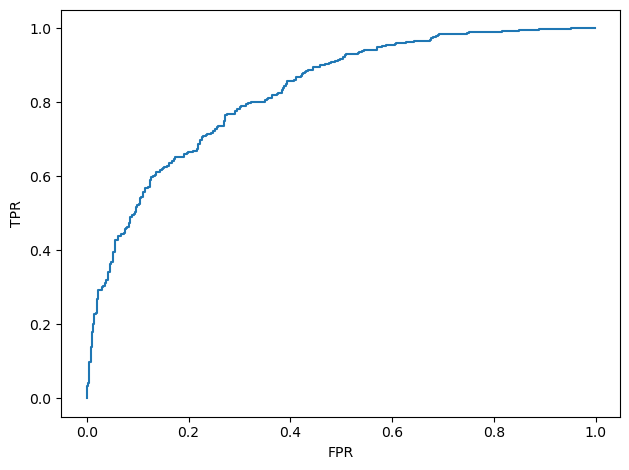

In [20]:
plt.figure()

points = []

for t in ts:
    cm = skmetrics.confusion_matrix(commedia_labels_infpar, commedia_llr_infpar > t)
    P_fn = cm[1, 0] / np.sum(cm[1, :])
    P_fp = cm[0, 1] / np.sum(cm[0, :])
    
    P_t = 1 - P_fn
    
    points.append((P_fp, P_t))
    
    
plt.plot([p[0] for p in points], [p[1] for p in points])
    
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.tight_layout()

plt.show()

# Bayes Error Plots


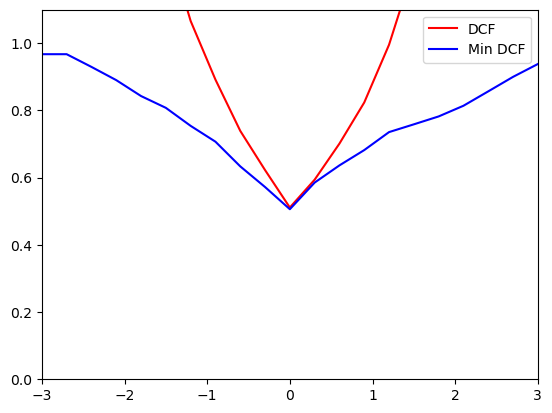

In [21]:
effPriorLogOdds = np.linspace(-3, 3, 21)

pis = [1 / (1 + np.exp(-p)) for p in effPriorLogOdds]

dcfs = [dcf(pi, 1, 1, optimal_bayes_threshold(pi, 1, 1), normalized=True) for pi in pis]
mindcf = []
for p in pis:
    best_dcf = None
    for t in ts:
        dcf_ = dcf(p, 1, 1, t, normalized=True)
        if best_dcf is None or dcf_ < best_dcf:
            best_dcf = dcf_
    mindcf.append(best_dcf)

plt.figure()
plt.plot(effPriorLogOdds, dcfs, label="DCF", color="r")
plt.plot(effPriorLogOdds, mindcf, label="Min DCF", color="b")
plt.ylim([0, 1.1])
plt.xlim([-3, 3])

plt.legend()

plt.show()

## Comparison with recognizer with $\epsilon = 1$


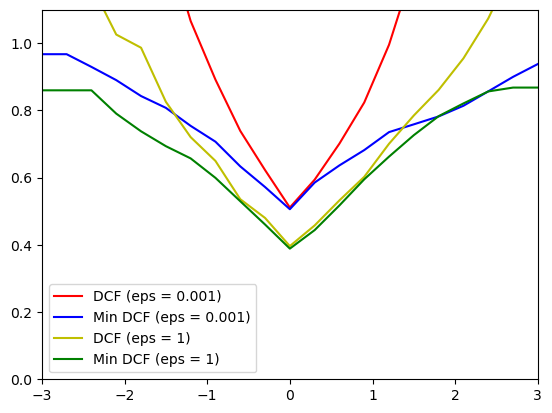

In [22]:
dcfs_p = [dcf(pi, 1, 1, optimal_bayes_threshold(pi, 1, 1), normalized=True, X=commedia_llr_infpar_eps1) for pi in pis]
mindcf_p = []
for p in pis:
    best_dcf = None
    for t in ts:
        dcf_ = dcf(p, 1, 1, t, normalized=True, X=commedia_llr_infpar_eps1)
        if best_dcf is None or dcf_ < best_dcf:
            best_dcf = dcf_
    mindcf_p.append(best_dcf)
    
plt.figure()

plt.plot(effPriorLogOdds, dcfs, label="DCF (eps = 0.001)", color="r")
plt.plot(effPriorLogOdds, mindcf, label="Min DCF (eps = 0.001)", color="b")
plt.plot(effPriorLogOdds, dcfs_p, label="DCF (eps = 1)", color="y")
plt.plot(effPriorLogOdds, mindcf_p, label="Min DCF (eps = 1)", color="g")

plt.ylim([0, 1.1])
plt.xlim([-3, 3])

plt.legend()

plt.show()


In [23]:
print(dcf(0.5, 1, 1, optimal_bayes_threshold(0.5, 1, 1), normalized=True, X=commedia_llr_infpar_eps1))
print(dcf(0.8, 1, 1, optimal_bayes_threshold(0.8, 1, 1), normalized=True, X=commedia_llr_infpar_eps1))
print(dcf(0.5, 10, 1, optimal_bayes_threshold(0.5, 10, 1), normalized=True, X=commedia_llr_infpar_eps1))
print(dcf(0.8, 1, 10, optimal_bayes_threshold(0.8, 1, 10), normalized=True, X=commedia_llr_infpar_eps1))

best_dcf = None
for t in ts:
    dcf_ = dcf(0.5, 1, 1, t, normalized=True, X=commedia_llr_infpar_eps1)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

best_dcf = None
for t in ts:
    dcf_ = dcf(0.8, 1, 1, t, normalized=True, X=commedia_llr_infpar_eps1)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

best_dcf = None
for t in ts:
    dcf_ = dcf(0.5, 10, 1, t, normalized=True, X=commedia_llr_infpar_eps1)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

best_dcf = None
for t in ts:
    dcf_ = dcf(0.8, 1, 10, t, normalized=True, X=commedia_llr_infpar_eps1)
    if best_dcf is None or dcf_ < best_dcf:
        best_dcf = dcf_
        
print(best_dcf)

0.3964303482587065
0.7480597014925373
1.0526119402985075
0.6581965174129353
0.3888432835820895
0.7000995024875623
0.8439054726368159
0.6036940298507462


# Multi-class Evaluation
